# Dleto on Toy data

CC-BY Peter Brooksbank, Martin Kassabov, and James B. Wilson

This notebook explores a data set about toys, specifically video game data.  This data is available from VG Chartz, all rights reserved.

First we need to load Julia and perhaps some necessary packages.

In [135]:
## Uncomment if you do not have iJulia installed
## it will take only one round to install, you can re-comment after that
# using Pkg
# Pkg.add("IJulia")
# This installs Julia's Jupyter kernel without Python dependencies
# println("IJulia installed! Restart VS Code and select Julia kernel.")

# Ensure Julia kernel is properly recognized  
# This notebook requires Julia kernel for execution and export
using IJulia
println("Julia kernel is active!")
println("Julia version: ", VERSION) # Fix Jupyter/Julia setup - Install IJulia for Julia notebooks

include("../Dleto.jl") 

Julia kernel is active!
Julia version: 1.10.3


plotTensor (generic function with 2 methods)

## Load some toy data.

We are using a Comma Separated Value (CSV) file of toy data.  We load this with Julia's DataFrames (Julia's version of R's data frame, similar to Python Pandas) and print a few values.  This may require you to install a couple packages, uncomment the necessary commands if that happens.  Once those are install you can remove those steps or comment them out again.

In [136]:

## Uncomment if you do not have these packages installed
## it will take only one round to install, you can re-comment after that
# import Pkg;
# Pkg.add("CSV")
# Pkg.add("DataFrames")

using CSV, DataFrames

# Load the CSV file
df = CSV.read("Video_Games.csv", DataFrame)
println("Loaded Video_Games.csv with ", nrow(df), " rows")

# Inspect the structure
println("Columns: ", names(df))
println(first(df, 5))


Loaded Video_Games.csv with 16719 rows
Columns: ["Name", "Platform", "Year_of_Release", "Genre", "Publisher", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales", "Critic_Score", "Critic_Count", "User_Score", "User_Count", "Developer", "Rating"]
5×16 DataFrame
 Row │ Name                      Platform  Year_of_Release  Genre         Publisher  NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  Critic_Score  Critic_Count  User_Score  User_Count  Developer  Rating   
     │ String?                   String7   String7          String15?     String     Float64   Float64   Float64   Float64      Float64       Int64?        Int64?        String3?    Int64?      String?    String7? 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Wii Sports                Wii       2006             Sports        Ninten

## Creating a data tensor

This is a good place to demonstrate creating a tensor from a data set.  
 * We treat every row of the CSV/DataFrame as contributing to an entry in the tensor.  
 * That axes of the tensor are individual columns.  We will demonstrate using "Platform", "Genre", "Critic Score"
 * For columns that are categories, the corresponding axis will have one basis vector for each category.  For example, in Platform we have Wii and NES. These could be mapped to $e_1$ and $e_2$.   Users familiar with one-hot encoding will recognize this encoding strategy only now we apply this just to individual axes.
 * For numeric columns we take actual values, or push them into a range of scores as the units.  For example, if scores are out of 100 we might take units of 10 similar to A,B,C,D, F grading. 

In [137]:
# Get unique values for each dimension
platforms = unique(skipmissing(df.Platform))
genres = unique(skipmissing(df.Genre))
scores = unique(skipmissing(df.Critic_Score))


println("Unique Platforms: ", length(platforms))
println("Unique Genres: ", length(genres))
println("Unique User Scores: ", length(scores))


Unique Platforms: 31
Unique Genres: 12
Unique User Scores: 82


Now we build up the tensor with entires being total sales.  Since each row of the data frame contributes to the data it is possible that several rows have the same platform, genre, and score.  This will then be used to add the total sales.  Our data is pretty course so we wont need full 64 bit floating points.

In [138]:
# Initialize tensor
t = zeros(Float16, length(platforms), length(genres), length(scores))
# Use Critic_Score instead of Year for the third dimension
critic_scores = unique(skipmissing(df.Critic_Score))
# Filter out "tbd" or non-numeric scores
critic_scores = filter(x -> tryparse(Float64, string(x)) !== nothing, critic_scores)
critic_scores = sort([parse(Float64, string(x)) for x in critic_scores])

# Reinitialize tensor with new dimensions
t = zeros(Float64, length(platforms), length(genres), length(critic_scores))
# Fill tensor with aggregated sales data
for row in eachrow(df)
    if !ismissing(row.Platform) && !ismissing(row.Genre) && !ismissing(row.Critic_Score)
        # Parse critic score
        score_str = string(row.Critic_Score)
        parsed_score = tryparse(Float64, score_str)
        
        if parsed_score !== nothing
            p_idx = findfirst(==(row.Platform), platforms)
            g_idx = findfirst(==(row.Genre), genres)
            s_idx = findfirst(==(parsed_score), critic_scores)
            
            if !isnothing(p_idx) && !isnothing(g_idx) && !isnothing(s_idx)
                # Aggregate global sales
                sales = get(row, :Global_Sales, 0.0)
                t[p_idx, g_idx, s_idx] += ismissing(sales) ? 0.0 : sales
            end
        end
    end
end

println("Created tensor with dimensions: ", size(t))
println("(", length(platforms), " platforms × ", length(genres), " genres × ", length(critic_scores), " critic scores)")
# t = loadTensorFromFile("../lstm_hidden_states_tensor.txt")
# t = loadTensorFromFile("../gnn_adjacency_tensor.txt")
println("Tensor loaded with size: ", size(t))

# plotTensor(t)

Created tensor with dimensions: (31, 12, 82)
(31 platforms × 12 genres × 82 critic scores)
Tensor loaded with size: (31, 12, 82)


### Visualization tools

This is a good place to look at the tensor we created.  You will need to have PlotlyJS active in your notebook, uncomment the command to install if you do not.

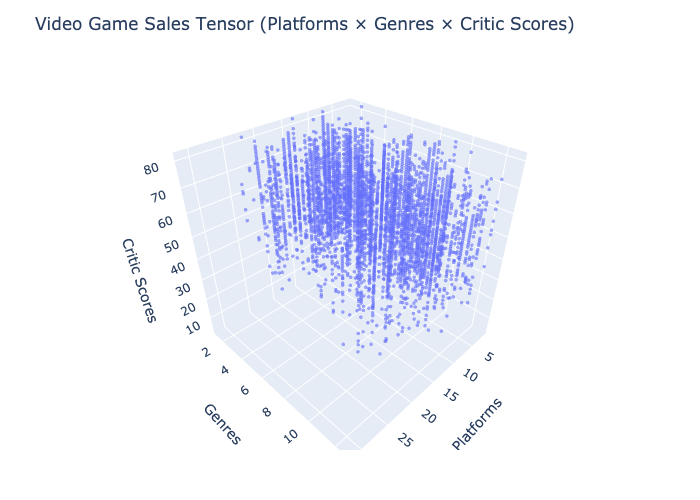

In [139]:
# import Pkg; Pkg.add("PlotlyJS") # Uncomment if PlotlyJS is not installed
plotTensor(t; xlabel="Platforms", ylabel="Genres", zlabel="Critic Scores", 
    title="Video Game Sales Tensor (Platforms × Genres × Critic Scores)")

We see here that not all the platforms are actually being used.  There is a lot of missing data.  There are tensor tools to detect such structure but it would be far more efficient to first go through some preliminary data processing to remove obvious issues.  In this case having built the tensor we will simply drop the platforms beyond 23.

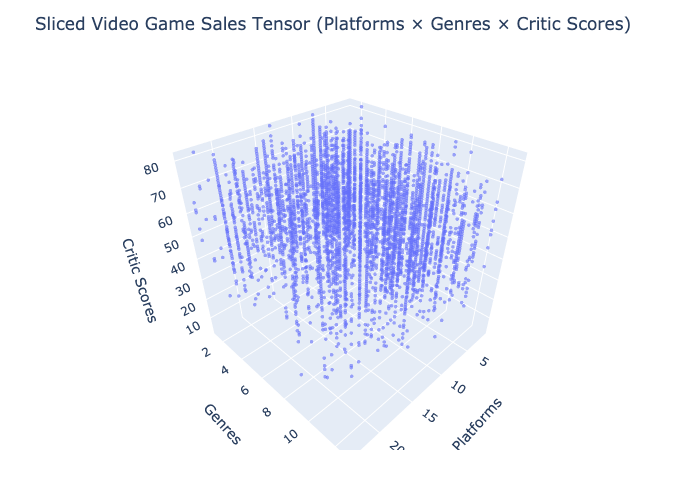

In [140]:

# Safely slice the tensor based on actual dimensions
dim1, dim2, dim3 = size(t)
t_trimmed = t[1:min(23, dim1), :, :]
plotTensor(t_trimmed; xlabel="Platforms", ylabel="Genres", zlabel="Critic Scores", 
    title="Sliced Video Game Sales Tensor (Platforms × Genres × Critic Scores)")

When tensors get larger we will want some general statistics to guide our analysis.  Often the data is wide ranging so we might drop small values or renormalize etc.  To explore one option we will simply drop small sales volumes.

In [141]:
dropSmall = x -> abs(x) < 1.0 ? 0 : x 
t_trimmed_big = t_trimmed .|> dropSmall

# Check current tensor dimensions
println("Current tensor size: ", size(t_trimmed_big) )

nonzeros_count = count(!iszero, t_trimmed_big); nonzeros_count_orig = count(!iszero, t)
total_length = length(t_trimmed_big); total_length_orig = length(t)
result = nonzeros_count / total_length; result_orig = nonzeros_count_orig / total_length_orig
println("Number of nonzeros: ", nonzeros_count, " down from ", nonzeros_count_orig)
println("Total length: ", total_length, " down from ", total_length_orig)
println("Ratio (nonzeros/length): ", result, " down from ", result_orig)

Current tensor size: (23, 12, 82)
Number of nonzeros: 1268 down from 4089
Total length: 22632 down from 30504
Ratio (nonzeros/length): 0.05602686461647225 down from 0.1340479937057435


For this size of data we can plot the resulting trimmed large value tensors.  You might notice for top sellers the scores do not go below 30.  We could trim this off as well.


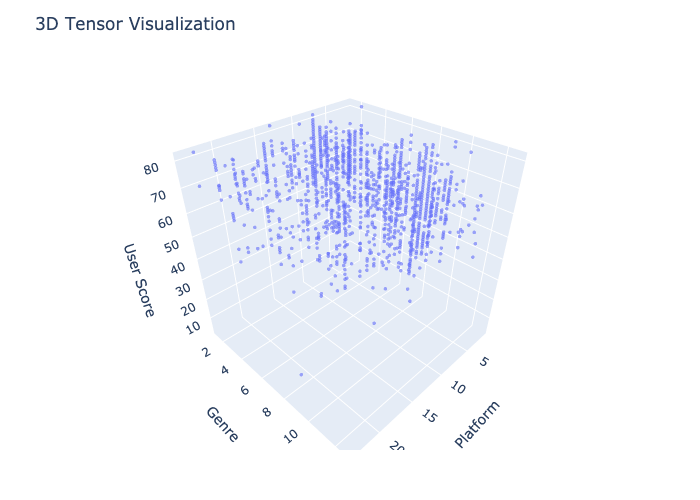

In [142]:
plotTensor(t_trimmed_big, 1.0; xlabel="Platform", ylabel="Genre", zlabel="User Score")

## Stratification

It is time to see what Dleto can chisel form this data.  Depending on the size of the data and the strategy selected this could take some time.  It is our present research question to improve on this timing.  So for now treat this as a demonstration of what you will get for this investment in time.

We will start with the full tensor, which takes about 120 seconds on an Apple M2 and uses 2.3 GB.

In [143]:
@time u = stratify(t)


	Building linear system...
	Sizes: (7829, 30504)
  1.177398 seconds (155.51 k allocations: 1.818 GiB, 53.63% gc time, 7.19% compilation time)

	Computing singular vectors for (7829, 30504)...
	
113.023646 seconds (48.81 k allocations: 2.291 GiB, 0.14% gc time)

	Extracting matrices...
  0.020545 seconds (6.52 k allocations: 484.328 KiB, 99.56% compilation time)
  0.000010 seconds (2 allocations: 2.438 KiB)
  0.000016 seconds (4 allocations: 105.344 KiB)
114.433477 seconds (997.21 k allocations: 4.163 GiB, 0.69% gc time, 0.26% compilation time)


(tensor = [-5.306175732112984e-21 6.928803297596588e-27 … -4.819207764151554e-21 0.0; -1.0402272770455921e-20 -9.65677752310357e-27 … -9.740908075523617e-22 0.0; … ; 1.5860213809999075e-22 7.553474130859457e-27 … -1.0093628943442131e-20 0.0; 1.2685315767245114e-30 7.9580234837497e-28 … 8.181778867458388e-30 0.0;;; -1.3478158745195227e-20 5.310678902013431e-17 … -8.693146976509959e-20 0.0; -4.5210131028547645e-20 -7.259638812425472e-17 … -2.9159644221987214e-19 0.0; … ; 1.2565578436026036e-20 5.740473250100093e-17 … 8.104550646248294e-20 0.0; 9.677038695503155e-21 5.879453795032771e-18 … 6.241499395930247e-20 0.0;;; 1.3478158746587176e-20 -5.310678902013278e-17 … 8.693146976370759e-20 0.0; 4.521013102584685e-20 7.259638812426113e-17 … 2.9159644222257283e-19 0.0; … ; -1.25655784354486e-20 -5.740473250100222e-17 … -8.104550646306025e-20 0.0; -9.677038695503128e-21 -5.879453795033934e-18 … -6.241499395930245e-20 0.0;;; … ;;; -8.122455354485157e-22 -4.9359222199025523e-17 … -5.2388237542180

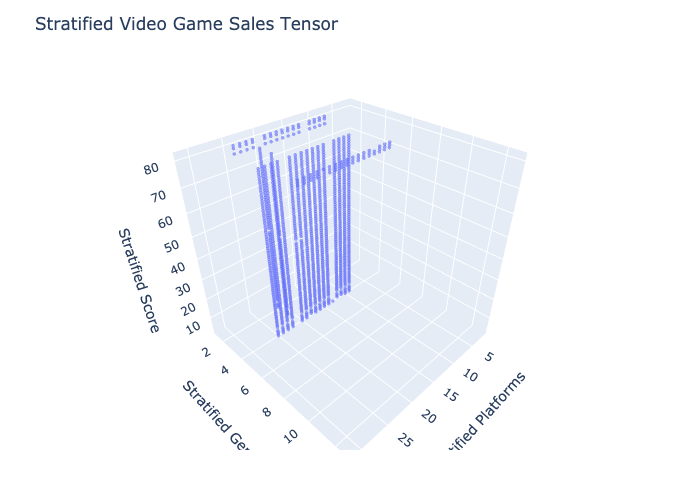

In [144]:
plotTensor(u.tensor,0.01; 
          xlabel="Stratified Platforms", 
          ylabel="Stratified Genre", 
          zlabel="Stratified Score", 
          title="Stratified Video Game Sales Tensor")

You will see in this that essentially concentrated one Genre combination but spread along many platforms and scores.  Some of these effects are the problem of using data with so many degeneracies.  Lets recompute on the trimmed tensor to compare.  This is smaller and the performance improves to about 90 seconds and 2 GB on an Apple M2.


In [112]:
@time v = stratify(t_trimmed)


	Building linear system...
  0.360429 seconds (67.90 k allocations: 1.271 GiB, 24.92% gc time)

	Computing singular vectors for (7397, 22632)...
	
 92.096162 seconds (48.66 k allocations: 2.045 GiB, 0.32% gc time)

	Extracting matrices...
  0.000039 seconds (2 allocations: 8.750 KiB)
  0.000001 seconds (2 allocations: 2.438 KiB)
  0.000022 seconds (4 allocations: 105.344 KiB)
 92.460003 seconds (117.03 k allocations: 3.318 GiB, 0.42% gc time)


(tensor = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.9203189482031027 -0.9203189482031255 … 0.9203189482031249 0.0002616722141290434; -0.0009569660528229152 -0.0009569660527667679 … 0.0009569660527790795 0.00964858572696222;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -1.1757928017764524e-11 -1.1907994640826e-11 … 1.1872909223852289e-11 -0.01192623676481066; -0.016568840342074787 -0.01656884034208043 … 0.016568840342078766 -0.0008593012571089603;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.09711357031929994 -0.0971135703192983 … 0.09711357031929457 1.3508255459859816e-15; -0.0015321916833303812 -0.0015321916833323128 … 0.0015321916833323799 1.280560820197343e-16;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 7.453800690943017e-26 1.7441539877204274e-26 … -3.1320887793788693e-26 7.950789723558117e-25; -1.9326884085394833e-15 3.847361757187688e-26 … -2.789334858319408e-26 5.701580989347786e-27;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -4.8637901901593324e-23 -4.8637901901594

We can plot the result and we see now there are 2 possibly 3 relevant score groups but not much separation in platforms.

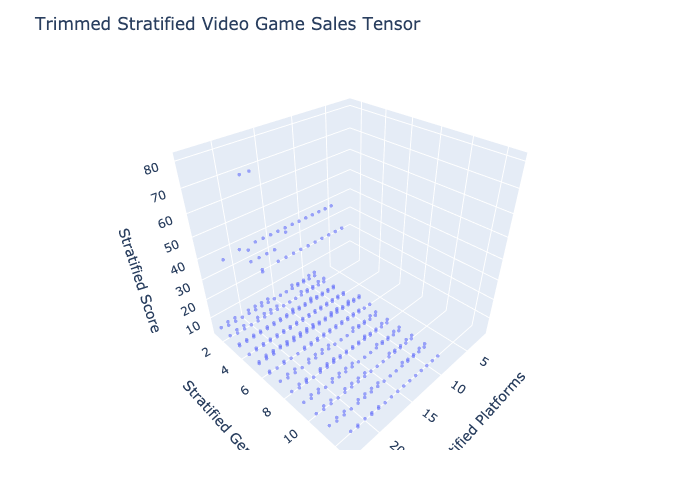

In [113]:
plotTensor(v.tensor; 
          xlabel="Stratified Platforms", 
          ylabel="Stratified Genre", 
          zlabel="Stratified Score", 
          title="Trimmed Stratified Video Game Sales Tensor")


We might now ask a number of questions:
 1. Is this reliable features or if I run this again will it find other structure?
 2. How do I see the actual combinations that lead to these clusters?
 3. Are their other clustering targets?

We can start by looking a the data labels the new combinations.  These are included in the output under cryptic labels (a future feature is to fix this).  Use `u.Xchange` (Platforms groups), `u.Ychange` (Genre groups), and `u.Zchange` (Score groups) and replace `u` with `v` to look a the second stratified tensor. 

If you print `v.Xchange` directly you get a matrix.  Each column corresponds to the vector of combinations that corresponds to the new coordinates in the resulting tensor.  So it may be more instructive to read this column-by-column.  


In [117]:
v.Xchange[:,1]

23-element Vector{Float64}:
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

This column is \(e_2\) which means this column did not change and it represents therefore 100% of the value of that original category.  Since this is the platform category this is the 2nd platform.  We can look this up.


In [119]:
println("Platform at index 2: ", platforms[2])

Platform at index 2: NES


Perhaps unsurprisingly for Video Game experts, Nintendo NES stands apart from other platforms.  But we should not jump to conclusions.  Perhaps what we are seeing is that no platforms changed.  Here inspecting the whole matrix can help us.

In [121]:
v.Xchange

23×23 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  …  -0.651445  -0.238525  -0.017186
 1.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0        0.0
 0.0  1.0  0.0  0.0  0.0  0.0      0.0        0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0      0.276399   0.971136   0.0153219
 0.0  0.0  0.0  0.0  0.0  0.0     -0.647963   0.0        0.0314286
 0.0  0.0  0.0  0.0  0.0  0.0  …   0.281723   0.0       -0.0654746
 0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0        0.00923796
 0.0  0.0  1.0  0.0  0.0  0.0      0.0        0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0        0.0330348
 0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0       -0.00391016
 ⋮                        ⋮    ⋱   ⋮                    
 0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0        0.00779529
 0.0  0.0  0.0  0.0  1.0  0.0  …   0.0        0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0        0.0129722
 0.0  0.0  0.0  0.0  0.0  0.0      0.0        0.0        0.129937
 0.0 

We see now that while the first several columns are unchanged, the final 3 columns are in combination.  Lets extract that combination.

In [124]:
new_platform = [(platforms[i], v.Xchange[i,21]) for i in 1:size(v.Xchange,1)]

23-element Vector{Tuple{String7, Float64}}:
 ("Wii", -0.65144497056809)
 ("NES", 0.0)
 ("GB", 0.0)
 ("DS", 0.27639862696314355)
 ("X360", -0.647962563073312)
 ("PS3", 0.2817228535101357)
 ("PS2", 0.0)
 ("SNES", 0.0)
 ("GBA", 0.0)
 ("PS4", 0.0)
 ⋮
 ("PC", 0.0)
 ("2600", 0.0)
 ("PSP", 0.0)
 ("XOne", 0.0)
 ("WiiU", 0.0)
 ("GC", 0.0)
 ("GEN", 0.0)
 ("DC", 0.0)
 ("PSV", 0.0)

We see that platform group 23 is now a combination of "Wii" (down by 65%), "DS" (up 28%), "X360" (down 64%), "PS3" (up 28%).  How to interpret this data will take a subject matter expert with experience in data science.  However, we might conjecture that the algorithm is identifying a habit in sales which would be perceived as stable across this combination of groups.  For example, that the sales Wii and XBox 360 sales negatively offset with "DS" and "PS2".  We might look at the entire tensor slice here to learn more.

In [125]:
v.tensor[21, :, :]

12×82 Matrix{Float64}:
  0.311924   -3.3562e-12   -0.0276398    …   8.31594e-15  -8.95102e-21
  0.311924   -3.3341e-12   -0.0276398       -1.3843e-23    0.0
  0.475084   -0.607006      0.0             -1.11854e-20   0.0
 -0.404618   -0.37527       0.0              0.0           0.0
 -2.01826    -0.7862       -0.0781498        1.35351e-12   0.0193479
  0.816651    0.0957858     0.0          …   0.0           0.0
 -0.311924    3.34531e-12   0.0276398        1.3843e-23    0.0
 -0.330004   -0.0219805     0.0275832       -3.66079e-23   0.0
 -0.311924    3.34475e-12   0.0276398        1.3408e-18   -1.44318e-24
 -0.311924    3.34507e-12   0.0276398        1.3843e-23    0.0
 -0.311924    3.3452e-12    0.0276398    …   1.3843e-23    0.0
 -0.0733776  -0.0325722     5.02517e-15      7.30764e-36   0.0

Since scores are the most pronounced clusters we should look at the Z-change (dropping small values to see better.)

In [129]:
v.Zchange .|> dropSmall

82×82 Matrix{Real}:
 0  0  0   0     0    0     0     0    …   0    0     0    0    0    0    0
 0  0  0  -1.0  -1.0  1.0  -1.0  -1.0     -1.0  1.0  -1.0  1.0  1.0  1.0  0
 0  0  0   0     0    0     0     0        0    0     0    0    0    0    0
 0  0  0   0     0    0     0     0        0    0     0    0    0    0    0
 0  0  0   0     0    0     0     0        0    0     0    0    0    0    0
 0  0  0   0     0    0     0     0    …   0    0     0    0    0    0    0
 0  0  0   0     0    0     0     0        0    0     0    0    0    0    0
 0  0  0   0     0    0     0     0        0    0     0    0    0    0    0
 0  0  0   0     0    0     0     0        0    0     0    0    0    0    0
 0  0  0   0     0    0     0     0        0    0     0    0    0    0    0
 ⋮                    ⋮                ⋱   ⋮                         ⋮    
 0  0  0   0     0    0     0     0        0    0     0    0    0    0    0
 0  0  0   0     0    0     0     0        0    0     0    0    0    

We should see what row 2 is about.

In [130]:
critic_scores[2]

17.0

## Other chisels

We close with other chisels.

In [131]:
@time s = toSurfaceTensor(t_trimmed)


	Building linear system...
  0.555177 seconds (124.96 k allocations: 677.101 MiB, 65.96% gc time, 9.52% compilation time)

	Computing singular vectors for (3757, 22632)...
	
 23.100818 seconds (48.64 k allocations: 542.963 MiB, 0.10% gc time)

	Extracting matrices...
  0.014835 seconds (7.76 k allocations: 581.875 KiB, 99.68% compilation time)
  0.000006 seconds (2 allocations: 1.250 KiB)
  0.000015 seconds (3 allocations: 52.703 KiB)
 23.758618 seconds (448.99 k allocations: 1.210 GiB, 1.64% gc time, 0.63% compilation time)


(tensor = [1.2775571871853449e-18 5.155402002490835e-18 … -5.0969416206526955e-18 -2.246396309277731e-18; -4.0343313143763076e-17 1.2875366159892006e-16 … -2.1655627644800206e-18 -4.581333016691393e-17; … ; -3.061606721336904e-17 7.186409999153987e-17 … 8.311871266127921e-18 -1.2133650360241247e-17; 6.575305295295524e-17 -2.0017088780764984e-17 … 3.060236869201986e-17 4.4873030356578225e-17;;; 1.639480438753792e-17 -3.350264694098166e-18 … -4.762273299843633e-18 3.521324502251401e-18; -5.872936714836394e-17 9.827897115829746e-17 … 5.679666050251801e-17 3.900096100886663e-17; … ; -6.987843368306937e-17 1.131742125238249e-16 … 1.2638966416528276e-16 -3.478613641959115e-17; -4.417644958443909e-17 1.3242607195832243e-17 … -3.374300755058791e-17 -8.423966342043285e-17;;; -1.6782692351672664e-18 -5.475925389480474e-18 … 6.86020696550795e-18 -1.7971103739165267e-19; -1.0431313442171118e-16 -8.444079243349558e-17 … 9.518056017435879e-17 6.368449992800978e-17; … ; -6.209750221872327e-17 -1.4292

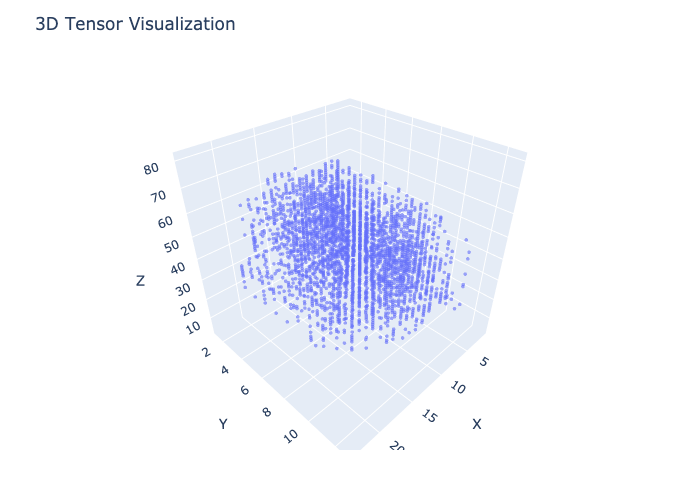

In [132]:

plotTensor(s.tensor, 1.0)

While surface chisels are great at recovering data like embedded surfaces that arise in PDEs, because they only use symmetric matrices and thus rotations, they are less capable of clustering in this setting.

In [133]:
@time f = toFaceCurveTensor(t)

  0.800605 seconds (337.43 k allocations: 178.064 MiB, 13.51% compilation time)


(tensor = [4.127357923217616e-19 -8.801944126500106e-19 … 3.933935585027017e-20 8.54362245370243e-19; -6.579714908678993e-18 1.4031805351483372e-17 … -6.271366598224714e-19 -1.361999639443108e-17; … ; -6.011054759494205e-18 1.2819088898680641e-17 … -5.7293558401849e-19 -1.2442871049480771e-17; 4.520853916841984e-20 -9.64110802125223e-20 … 4.308990988673154e-21 9.358158355146673e-20;;; -1.7535649757181358e-17 -4.293105527883586e-18 … -1.6587158137189638e-17 1.529460337663417e-17; 2.7954826861914473e-16 6.843944957486663e-17 … 2.6442768889498214e-16 -2.438221538613721e-16; … ; 2.553879573680258e-16 6.25244839349371e-17 … 2.4157419279331005e-16 -2.2274951708094344e-16; -1.920747179283164e-18 -4.702403644706916e-19 … -1.8168552432043922e-18 1.6752767476947393e-18;;; 1.4490125525927546e-17 2.6049080764374815e-17 … 8.938151577358858e-18 1.242111476771801e-17; 3.2834457667110824e-16 5.69836924066561e-16 … 1.4610603007659975e-16 2.8021264198591536e-16; … ; 1.8031952703151018e-16 2.849668189424

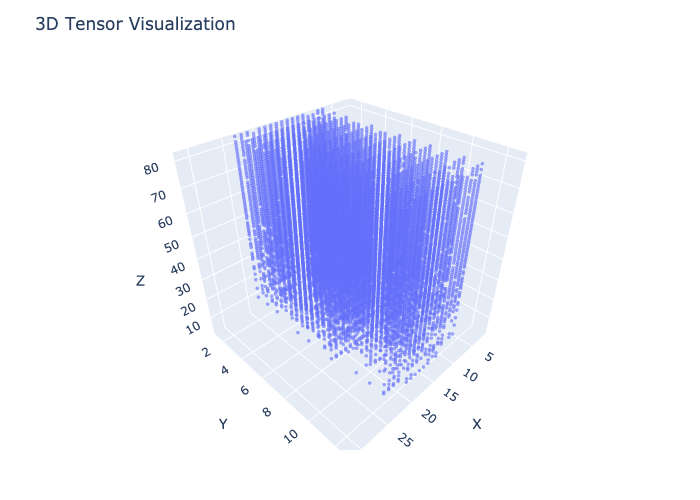

In [134]:
plotTensor(f.tensor)

In [ ]:
@time c = toCurveTensor(t)
plotTensor(c.tensor)